# Primer Modelo GAN

## Imports y descarga del dataset

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random

from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv2D,Conv2DTranspose, Dense, Activation, Flatten, Reshape, Dropout, UpSampling2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.optimizers import Adam
from keras.layers import Input, concatenate
from tensorflow.keras.layers import Cropping2D

Descargamos el dataset de Kaggle, simplemente con acceso a una cuenta de la página tenemos acceso de esta manera. Guardamos el dataset en una carpeta en el entorno de Colab llamada: **imagenesOriginales**. Si quiere ver el dataset, haga click [aquí](https://www.kaggle.com/datasets/arnaud58/landscape-pictures).

In [ ]:
from google.colab import files
import os
import json

uploaded = files.upload()


# Configurar las credenciales de Kaggle
with open('kaggle.json') as f:
    kaggle_credentials = json.load(f)


os.environ['KAGGLE_USERNAME'] = kaggle_credentials['username']
os.environ['KAGGLE_KEY'] = kaggle_credentials['key']


# Descargar el conjunto de datos (reemplaza 'nombre_del_conjunto_de_datos' y 'nombre_del_usuario' con tu información)
!kaggle datasets download -d arnaud58/landscape-pictures
# Descomprimir el archivo descargado
!unzip landscape-pictures.zip -d ImagenesOriginales

Saving kaggle.json to kaggle.json
 98% 610M/620M [00:05<00:00, 46.3MB/s]
100% 620M/620M [00:05<00:00, 118MB/s] 
Archive:  landscape-pictures.zip
  inflating: ImagenesOriginales/00000000.jpg  
  inflating: ImagenesOriginales/00000000_(2).jpg  
  inflating: ImagenesOriginales/00000000_(3).jpg  
  inflating: ImagenesOriginales/00000000_(4).jpg  
  inflating: ImagenesOriginales/00000000_(5).jpg  
  inflating: ImagenesOriginales/00000000_(6).jpg  
  inflating: ImagenesOriginales/00000000_(7).jpg  
  inflating: ImagenesOriginales/00000001.jpg  
  inflating: ImagenesOriginales/00000001_(2).jpg  
  inflating: ImagenesOriginales/00000001_(3).jpg  
  inflating: ImagenesOriginales/00000001_(4).jpg  
  inflating: ImagenesOriginales/00000001_(5).jpg  
  inflating: ImagenesOriginales/00000001_(6).jpg  
  inflating: ImagenesOriginales/00000001_(7).jpg  
  inflating: ImagenesOriginales/00000002.jpg  
  inflating: ImagenesOriginales/00000002_(2).jpg  
  inflating: ImagenesOriginales/00000002_(3).jpg  


## Tratado de Imagenes

Ya que las imágenes originales del dataset tienen una calidad con la que no podemos tratar con los recursos actuales (1024,1024), las redimensionamos a (128,128), y las guardamos en el entorne en la carpeta: **imagenesRedimensionadas**.

In [ ]:
import os
import cv2
import numpy as np

# Ruta del directorio que contiene las imágenes
directorio_imagenes = '/content/ImagenesOriginales'

# Obtener la lista de archivos en el directorio
archivos = os.listdir(directorio_imagenes)

# Directorio de salida para las imágenes de baja calidad
directorio_salida = 'imagenesRedimensionadas'
os.makedirs(directorio_salida, exist_ok=True)

# Redimensionar la imagen a 128x128 píxeles
nuevo_tamano = (128, 128)

# Reducir la calidad de las imágenes y guardarlas en el nuevo directorio
for archivo in archivos:
    # Verificar si es un archivo de imagen
    if archivo.endswith('.jpg') or archivo.endswith('.png'):
        # Cargar la imagen
        imagen_path = os.path.join(directorio_imagenes, archivo)
        imagen = cv2.imread(imagen_path)
        imagen_redimensionada = cv2.resize(imagen, nuevo_tamano)

        # Crear el nombre del archivo de salida
        nombre_archivo_salida = os.path.join(directorio_salida, archivo)

        # Guardar la imagen redimensionada
        cv2.imwrite(nombre_archivo_salida, imagen_redimensionada)

La idea detrás de este modelo es introducirle de entrada al generador imágenes del dataset con solo una parte visible, la esquina superior derecha (64,64), con el resto de la imagen en negro, de esta manera esperamos que sea capaz de "rellenar" el resto de información con un contexto nuevo. Para hacer esto, necesitamos modificar las imágenes de esta manera para introducirlas al generador. Este será el siguiente paso, guardando las imágenes en la carpeta del entorno: **imagenesModificadas**

In [ ]:

# Directorio de entrada y salida
directorio_entrada = '/content/imagenesRedimensionadas'
directorio_salida = '/content/imagenesModificadas/'

# Crear el directorio de salida si no existe
os.makedirs(directorio_salida, exist_ok=True)

# Tamaño del cuadrado en la esquina superior izquierda en píxeles
tamanio_cuadrado = 64  # Ajusta este valor según tus preferencias

# Obtener la lista de archivos en el directorio de entrada
archivos = os.listdir(directorio_entrada)

# Iterar sobre cada archivo en el directorio de entrada
for archivo in archivos:
    # Crear la ruta completa de la imagen de entrada
    ruta_entrada = os.path.join(directorio_entrada, archivo)

    # Leer la imagen de entrada
    imagen = cv2.imread(ruta_entrada)

    # Crear una imagen completamente negra
    imagen_negra = np.zeros_like(imagen)

    # Copiar el cuadrado de la imagen original a la imagen negra
    imagen_negra[:tamanio_cuadrado, :tamanio_cuadrado, :] = imagen[:tamanio_cuadrado, :tamanio_cuadrado, :]

    # Crear la ruta completa de la imagen de salida
    ruta_salida = os.path.join(directorio_salida, archivo)

    # Guardar la imagen modificada en el directorio de salida
    cv2.imwrite(ruta_salida, imagen_negra)

Lo siguiente es formar el X_train que introduciremos al generador a partir de las imágenes de dicha carpeta. Podemos ver en la imagen imprimida un ejemplo de el estilo de imagenes de entrada al generador.

Forma de X_train:  (4319, 128, 128, 3)


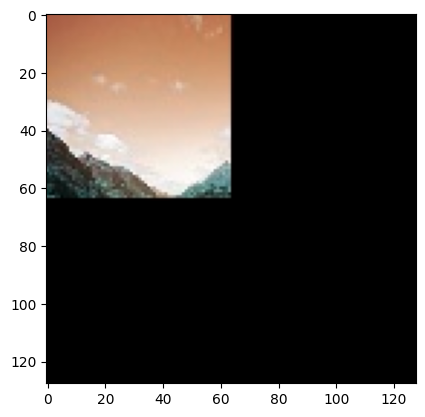

In [ ]:
from sklearn.model_selection import train_test_split
import os
import cv2
import numpy as np

# Ruta del directorio que contiene las imágenes
directorio_imagenes = '/content/imagenesModificadas'

# Obtener la lista de archivos en el directorio
archivos = os.listdir(directorio_imagenes)

# Lista para almacenar las imágenes
imagenes = []

# Leer las imágenes
for archivo in archivos:
    # Verificar si es un archivo de imagen
    if archivo.endswith('.jpg') or archivo.endswith('.png'):
        # Cargar la imagen
        imagen_path = os.path.join(directorio_imagenes, archivo)
        imagen = cv2.imread(imagen_path)

        # Puedes realizar cualquier preprocesamiento necesario aquí

        # Añadir la imagen a la lista
        imagenes.append(imagen)

# Convertir la lista a un array de numpy
X_train = np.array(imagenes)


# Imprimir la forma del conjunto
plt.imshow(X_train[1])
print("Forma de X_train: ", X_train.shape)




Para actuar como dataset de imágenes reales para introducir al discriminador junto a las generadas por el generador, creamos X_train_Reales, a partir de las imagenes redimensionadas pero sin recortar. Podemos ver un ejemplo impreso.

Forma de X_train_Reales:  (4319, 128, 128, 3)


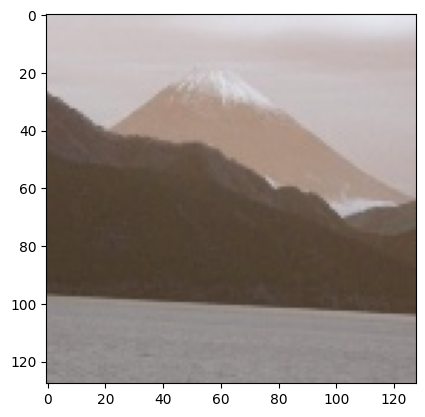

In [ ]:

# Ruta del directorio que contiene las imágenes
directorio_imagenes = '/content/imagenesRedimensionadas'

# Obtener la lista de archivos en el directorio
archivos = os.listdir(directorio_imagenes)

# Lista para almacenar las imágenes
imagenes = []

# Leer las imágenes
for archivo in archivos:
    # Verificar si es un archivo de imagen
    if archivo.endswith('.jpg') or archivo.endswith('.png'):
        # Cargar la imagen
        imagen_path = os.path.join(directorio_imagenes, archivo)
        imagen = cv2.imread(imagen_path)

        # Puedes realizar cualquier preprocesamiento necesario aquí

        # Añadir la imagen a la lista
        imagenes.append(imagen)

# Convertir la lista a un array de numpy
X_train_Reales = np.array(imagenes)


# Imprimir la forma del conjunto
print("Forma de X_train_Reales: ", X_train_Reales.shape)

plt.imshow(X_train_Reales[7])

Normalizamos ambos conjuntos en el rango [-1,1]

In [ ]:
X_train = X_train.astype('float32')/127.5 -1
X_train_Reales = X_train.astype('float32')/127.5 -1


## Train y funciones de plot

Funcion de entrenamiento como las vistas en clase para estos modelos. Cabe remarcar que dado que al generador no le introducimos un ruido aleatorio, se debe introducir un conjunto de imágenes de X_train. Tanto el conjunto de imágenes que introducir al generador o al modelo completo, como las reales que introducir al discriminador se seleccionan de manera aleatoria de X_train y X_train_Reales respectivamente.

In [ ]:
def train(X_train, generator, discriminator, combined, epochs, batch_size=32, sample_interval=100):
    # Adversarial ground truths (-1 fake and 1 real)
    valid = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    history = {
        'd_loss' : [],
        'd_acc' : [],
        'g_loss' : []
    }

    for epoch in range(epochs):
        print("----EPOCH " + str(epoch) + '-----')
        for batch in range(int(len(X_train)/batch_size)):
            #  Train the Discriminator
            import random

              # Definir el número de imágenes a pasar por el modelo en este batch
            num_imagenes_seleccionar = batch_size

              # Obtener índices aleatorios de las imágenes en X_train
            indices_seleccionados = random.sample(range(X_train.shape[0]), num_imagenes_seleccionar)

              # Seleccionar las imágenes correspondientes a los índices
            X_subset = X_train[indices_seleccionados]


             # Metemos las imagenes de entrada aleatorias de input al generador, para obtener la prediccion
            gen_imgs = generator.predict(X_subset, verbose=0)

             # Definir el número de imágenes a pasar al discriminador (REALES)
            indices_seleccionados = random.sample(range(X_train_Reales.shape[0]), num_imagenes_seleccionar)
            imgs = X_train_Reales[indices_seleccionados]

            d_loss_real = discriminator.train_on_batch(imgs, valid)
            d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # Train the Generator
              # Volvemos a seleccionar un conjunto aleatorio de X_train
            indices_seleccionados = random.sample(range(X_train.shape[0]), num_imagenes_seleccionar)
            X_subset = X_train[indices_seleccionados]

            g_loss = combined.train_on_batch(X_subset, valid)

            # Save losses
            history['d_loss'].append(d_loss[0])
            history['d_acc'].append(d_loss[1])
            history['g_loss'].append(g_loss)

            # Plot the progress
            if batch % 50 == 0:
                print ("%d [D loss: %.4f,\t acc.: %.2f%%]\t[G loss: %.4f]" % (batch, d_loss[0], 100*d_loss[1], g_loss))

            if batch % 500 == 0:
                sample_images(epoch, batch, gen_imgs, imgs)

        plot_losses(history)


Funciones de plot modificadas para trabajar con colores RGB.

In [ ]:
def sample_images(epoch, batch, gen_imgs, imgs):
    plt.rcParams['figure.figsize'] = [15, 5]
    fig, axs = plt.subplots(2, 5)
    fig.suptitle('Epoch: ' + str(epoch) + ', Batch: ' + str(batch), fontsize=16)
    for i in range(5):
        axs[0,i].imshow(cv2.cvtColor(gen_imgs[i], cv2.COLOR_BGR2RGB))
        axs[0,i].axis('off')

    for i in range(5):
        axs[1,i].imshow(cv2.cvtColor(imgs[i], cv2.COLOR_BGR2RGB))
        axs[1,i].axis('off')
    plt.show()
    plt.close()

In [ ]:
def plot_losses(history):
    plt.rcParams['figure.figsize'] = [20, 5]
    f, (ax1, ax2) = plt.subplots(1, 2, sharex=True)

    ax1.set_title('Losses')
    ax1.set_xlabel('epoch')
    ax1.legend(loc="upper right")
    ax1.grid()

    ax1.plot(history['d_loss'], label='D loss')
    ax1.plot(history['g_loss'], label='G loss')
    ax1.legend()

    ax2.set_title('D accuracy')
    ax2.set_xlabel('epoch')
    ax2.legend(loc="upper right")
    ax2.grid()

    ax2.plot(history['d_acc'], label='Accuracy')
    ax2.legend()

    plt.show()
